In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [2]:
from torch import nn, Tensor

In [3]:
import tensorflow as tf

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
import math
class PositionalEncoder(nn.Module):

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=6,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [29]:
class TimeSeriesTransformer(nn.Module):

    """
    This class implements a transformer model that can be used for times series
    forecasting. 
    """

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool, 
        out_seq_len: int=51,
        dim_val: int=6, 
        n_encoder_layers: int=1,
        n_decoder_layers: int=1,
        n_heads: int=2,
        dropout_encoder: float=0.1, 
        dropout_decoder: float=0.1,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=1024,
        dim_feedforward_decoder: int=1024,
        num_predicted_features: int=8
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        print("input_size is: {}".format(input_size))
        print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        # print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        # print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        # print("From model.forward(): Size of src after encoder: {}".format(src.size()))
        
        """
        THIS IS MY TEMPORAL EMEBBING
        
        """

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        # print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        # print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        # print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))
#         decoder_output = torch.nn.Softmax()(decoder_output) #add activation


        return src, decoder_output

In [30]:
import os
import numpy as np
from torch import nn, Tensor
from typing import Optional, Any, Union, Callable, Tuple
import torch
import pandas as pd
from pathlib import Path


class utils:
    def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
        """
        Args:
            dim1: int, for both src and tgt masking, this must be target sequence
              length
            dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
        Return:
            A Tensor of shape [dim1, dim2]
        """
        return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


    def get_indices_input_target(num_obs, input_len, step_size, forecast_horizon, target_len):
        """
          Produce all the start and end index positions of all sub-sequences.
          The indices will be used to split the data into sub-sequences on which 
          the models will be trained. 
          Returns a tuple with four elements:
          1) The index position of the first element to be included in the input sequence
          2) The index position of the last element to be included in the input sequence
          3) The index position of the first element to be included in the target sequence
          4) The index position of the last element to be included in the target sequence
          
          Args:
              num_obs (int): Number of observations in the entire dataset for which
                              indices must be generated.
              input_len (int): Length of the input sequence (a sub-sequence of 
                              of the entire data sequence)
              step_size (int): Size of each step as the data sequence is traversed.
                              If 1, the first sub-sequence will be indices 0-input_len, 
                              and the next will be 1-input_len.
              forecast_horizon (int): How many index positions is the target away from
                                      the last index position of the input sequence?
                                      If forecast_horizon=1, and the input sequence
                                      is data[0:10], the target will be data[11:taget_len].
              target_len (int): Length of the target / output sequence.
        """
        start_position = 0
        stop_position = num_obs-1 # because of 0 indexing
          
        subseq_first_idx = start_position
        subseq_last_idx = start_position + input_len
        target_first_idx = subseq_last_idx + forecast_horizon
        target_last_idx = target_first_idx + target_len 
        # print("target_last_idx is {}".format(target_last_idx))
        # print("stop_position is {}".format(stop_position))
        indices = []
        while target_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_last_idx, target_first_idx, target_last_idx))
            subseq_first_idx += step_size
            subseq_last_idx += step_size
            target_first_idx = subseq_last_idx + forecast_horizon
            target_last_idx = target_first_idx + target_len

        return indices

    def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:
        """
          Produce all the start and end index positions that is needed to produce
          the sub-sequences. 
          Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
          sequence. These tuples should be used to slice the dataset into sub-
          sequences. These sub-sequences should then be passed into a function
          that slices them into input and target sequences. 
          
          Args:
              num_obs (int): Number of observations (time steps) in the entire 
                            dataset for which indices must be generated, e.g. 
                            len(data)
              window_size (int): The desired length of each sub-sequence. Should be
                                (input_sequence_length + target_sequence_length)
                                E.g. if you want the model to consider the past 100
                                time steps in order to predict the future 50 
                                time steps, window_size = 100+50 = 150
              step_size (int): Size of each step as the data sequence is traversed 
                              by the moving window.
                              If 1, the first sub-sequence will be [0:window_size], 
                              and the next will be [1:window_size].
          Return:
              indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
          
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
          
        subseq_last_idx = window_size
          
        indices = []
          
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
              
            subseq_first_idx += step_size
              
            subseq_last_idx += step_size

        return indices

    def to_numeric_and_downcast_data(df: pd.DataFrame):
        """
        Downcast columns in df to smallest possible version of it's existing data
        type
        """
        fcols = df.select_dtypes('float').columns
    
        icols = df.select_dtypes('integer').columns

        df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    
        df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

        return df


In [31]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from typing import Tuple

class TransformerDataset(Dataset):
    """
    Dataset class used for transformer models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        indices: list, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> None:

        """
        Args:
            data: tensor, the entire train, validation or test data sequence 
                        before any slicing. If univariate, data.size() will be 
                        [number of samples, number of variables]
                        where the number of variables will be equal to 1 + the number of
                        exogenous variables. Number of exogenous variables would be 0
                        if univariate.
            indices: a list of tuples. Each tuple has two elements:
                     1) the start index of a sub-sequence
                     2) the end index of a sub-sequence. 
                     The sub-sequence is split into src, trg and trg_y later.  
            enc_seq_len: int, the desired length of the input sequence given to the
                     the first layer of the transformer model.
            target_seq_len: int, the desired length of the target sequence (the output of the model)
            target_idx: The index position of the target variable in data. Data
                        is a 2D tensor
        """
        
        super().__init__()

        self.indices = indices

        self.data = data

        # print("From get_src_trg: data size = {}".format(data.size()))

        self.enc_seq_len = enc_seq_len

        self.dec_seq_len = dec_seq_len

        self.target_seq_len = target_seq_len



    def __len__(self):
        
        return len(self.indices)

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]

        sequence = self.data[start_idx:end_idx]

        #print("From __getitem__: sequence length = {}".format(len(sequence)))

        src, trg, trg_y = self.get_src_trg(
            sequence=sequence,
            enc_seq_len=self.enc_seq_len,
            dec_seq_len=self.dec_seq_len,
            target_seq_len=self.target_seq_len
            )

        return src, trg, trg_y
    
    def get_src_trg(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]
        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len]

In [32]:
# import dataset as ds
# import utils
from torch.utils.data import DataLoader
import torch
import datetime
# import transformer_timeseries as tst
import numpy as np
from sklearn.model_selection import train_test_split

# Read data
data = pd.read_hdf("normal.h5")
data.drop('isAttack', inplace=True, axis=1)
# data= data[0:4980]

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


for i in range(data.shape[1]):
      if max(data.iloc[:,i])!= min(data.iloc[:,i]):
        data.iloc[:,i] = norm(data.iloc[:,i])


list_cols = list(data.columns)

# Hyperparams
batch_size = 128
target_col_name = list_cols


## Params
dim_val = 6
n_heads = 2
n_decoder_layers = 1
n_encoder_layers = 1
dec_seq_len = 8 # length of input given to decoder
enc_seq_len = 25 # length of input given to encoder
output_sequence_length = 8 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 5 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 1024
in_features_decoder_linear_layer = 1024
max_seq_len = enc_seq_len
batch_first = False

# Define input variables 
exogenous_vars = [] # should contain strings. Each string must correspond to a column name
input_variables = target_col_name 
print(input_variables)
target_idx = 0 # index position of target in batched trg_y


# # Remove test data from dataset
# training_data = data[:-(round(len(data)*test_size))]

TRAIN_SPLIT=0.7
VAL_SPLIT=0.5

training_data, val_data = train_test_split(data, train_size=TRAIN_SPLIT, shuffle=False, random_state=123)
val_data, test_data = train_test_split(val_data, train_size=VAL_SPLIT, shuffle=False, random_state=123)

# Make list of (start_idx, end_idx) pairs that are used to slice the time series sequence into chunkc. 
# Should be training data indices only
training_indices = utils.get_indices_entire_sequence(
    data=training_data, 
    window_size=window_size, 
    step_size=step_size)

# Making instance of custom dataset class
training_data = TransformerDataset(
    data=torch.tensor(training_data[input_variables].values).float(),
    indices=training_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

val_indices = utils.get_indices_entire_sequence(
    data=val_data, 
    window_size=window_size, 
    step_size=step_size)

val_data = TransformerDataset(
    data=torch.tensor(val_data[input_variables].values).float(),
    indices=val_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

test_indices = utils.get_indices_entire_sequence(
    data=test_data, 
    window_size=window_size, 
    step_size=step_size)

test_data = TransformerDataset(
    data=torch.tensor(test_data[input_variables].values).float(),
    indices=test_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

# Making dataloader
training_data = DataLoader(training_data, batch_size)
val_data = DataLoader(val_data, batch_size)
test_data = DataLoader(test_data, batch_size)

transformer_model = TimeSeriesTransformer(
    input_size=25,
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features= output_sequence_length 
    )

['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']
input_size is: 25
dim_val is: 6


In [33]:
data.shape

(496800, 51)

In [34]:
PATH = ('transformer_model_2.pth')

In [35]:
# # optimizer = torch.optim.RMSprop(transformer_model.parameters(), 
# #                                 lr=0.0005)

optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.000025, betas=(0.9, 0.98), eps=1e-9)

In [36]:
transformer_model

TimeSeriesTransformer(
  (encoder_input_layer): Linear(in_features=25, out_features=6, bias=True)
  (decoder_input_layer): Linear(in_features=8, out_features=6, bias=True)
  (linear_mapping): Linear(in_features=6, out_features=8, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=6, bias=True)
        (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inpl

In [37]:
from tqdm import tqdm
transformer_model.to(device)

n_epochs = 10
niter = len(training_data)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):

    transformer_model.train()
    sum_train_loss = 0.0
    
    
    for src, tgt, tgt_y in training_data:
        if batch_first == False:
            src = src.permute(2, 0, 1).to(device)
            tgt = tgt.permute(2, 0, 1).to(device)
            tgt_y = tgt_y.permute(2, 0, 1).to(device)
            
        src_mask = utils.generate_square_subsequent_mask(
              dim1 = tgt.shape[0],
              dim2 = src.shape[0]
            ).to(device)
        tgt_mask = utils.generate_square_subsequent_mask( 
              dim1= tgt.shape[0],
              dim2= tgt.shape[0]
            ).to(device)

        temporal_embedding, output = transformer_model(
          src=src,
          tgt=tgt,
          src_mask=src_mask,
          tgt_mask=tgt_mask
          )
        loss = torch.nn.MSELoss()(output, tgt_y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)



    transformer_model.eval()
    sum_val_loss = 0.0

    for i, (src, tgt, tgt_y) in enumerate(val_data):
        if batch_first == False:
            src = src.permute(2, 0, 1).to(device) 
            tgt = tgt.permute(2, 0, 1).to(device)
            tgt_y = tgt_y.permute(2, 0, 1).to(device)

        src_mask = utils.generate_square_subsequent_mask(
                dim1 = tgt.shape[0],
                dim2 = src.shape[0]
                ).to(device)

        tgt_mask = utils.generate_square_subsequent_mask( 
                  dim1= tgt.shape[0],
                  dim2= tgt.shape[0]
                ).to(device)

        temporal_embedding, output = transformer_model(
          src=src,
          tgt=tgt,
          src_mask=src_mask,
          tgt_mask=tgt_mask
          )
        val_loss = torch.nn.MSELoss()(output, tgt_y)
#         print(val_loss)
        sum_val_loss += val_loss.item()
    val_losses.append(sum_val_loss / (i+1))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.22s/it]


In [15]:
# losses

In [16]:
# val_losses

In [17]:
# sum_train_loss

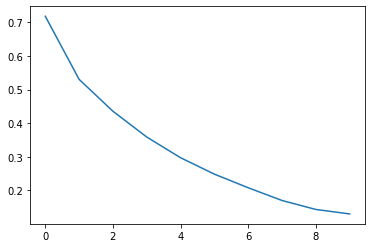

In [38]:
plt.plot(losses)

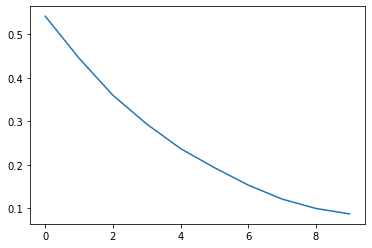

In [39]:
plt.plot(val_losses)

In [40]:
torch.save(transformer_model.state_dict(),PATH)

In [41]:
transformer_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [42]:
# def mean_absolute_percentage_error(y_true, y_pred): 
#       y_true, y_pred = torch.tensor(y_true), torch.tensor(y_pred)
#       return torch.mean(torch.abs((y_true - y_pred)/y_true)*100)
                      
test_losses_mape, test_losses_mae, test_losses_mse, test_preds  = [], [], [], []
transformer_model.eval()

for src, tgt, tgt_y in test_data:
        if batch_first == False:
            src = src.permute(2,0,1).to(device)
            tgt = tgt.permute(2, 0, 1).to(device)
            tgt_y = tgt_y.permute(2, 0, 1).to(device)

        src_mask = utils.generate_square_subsequent_mask(
                dim1 = tgt.shape[0],
                dim2 = src.shape[0]
                ).to(device)

        tgt_mask = utils.generate_square_subsequent_mask( 
                  dim1= tgt.shape[0],
                  dim2= tgt.shape[0]
                ).to(device)

        temporal_embedding, output = transformer_model(
          src=src,
          tgt=tgt,
          src_mask=src_mask,
          tgt_mask=tgt_mask
          )
      
      
        loss_test_mae = torch.nn.L1Loss()(output, tgt_y)
        test_losses_mae.append(loss_test_mae.item())

        loss_test_mse = torch.nn.MSELoss()(output, tgt_y)
        test_losses_mse.append(loss_test_mse.item())
#         output_test = output.permute(1,0,2)
#         test_preds.append(output.detach().cpu().numpy())
# test_preds = np.vstack(test_preds)

print("mean MAE loss over the test dataset is={}". format(np.mean(test_losses_mae)))
print("mean MSE loss over the test dataset is={}". format(np.mean(test_losses_mse)))
      



mean MAE loss over the test dataset is=0.1958842584465304
mean MSE loss over the test dataset is=0.08892400932108235


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer(
    input_size=25,
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features= output_sequence_length 
    ).to(device)

PATH = 'transformer_model_2.pth'
model.load_state_dict(torch.load(PATH))

input_size is: 25
dim_val is: 6


<All keys matched successfully>

In [44]:
def get_temporal_embedding(data, model, batch_first=False):
    
    model.eval()
    with torch.no_grad():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        temporal_embedding=[]
        for src, tgt, tgt_y in data:
            if batch_first == False:
                src = src.permute(2,0,1).to(device)

            src = model.encoder_input_layer(src) 
            src = model.positional_encoding_layer(src) 

            temp_embedding = model.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
                            src=src
                            )
        
            temp_embedding = temp_embedding.cpu()
            
            temporal_embedding.append(temp_embedding)
        
    return temporal_embedding

In [45]:
def mod_temp_embeds(X):
    temp_embed = []
    
    for i in range(X.shape[0]):
        item = X[i]
        item = torch.squeeze(item)
        item.to('cpu')
        item = item.numpy()
        temp_embed.append(item)
        
    temp_embed = np.asarray(temp_embed)
    return temp_embed

In [46]:
#normal_dataset

normal_data = pd.read_hdf("normal.h5")
normal_data.drop('isAttack', inplace=True, axis=1)
# normal_data = normal_data[0:4980]


def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


for i in range(normal_data.shape[1]):
      if max(normal_data.iloc[:,i])!= min(normal_data.iloc[:,i]):
        normal_data.iloc[:,i] = norm(normal_data.iloc[:,i])

normal_indices = utils.get_indices_entire_sequence(
    data=data, 
    window_size=window_size, 
    step_size=step_size)

normal_data = TransformerDataset(
    data=torch.tensor(data[input_variables].values).float(),
    indices=normal_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

# # Making dataloader
normal_data = DataLoader(normal_data, batch_size=1)


# attack_dataset

attack_data = pd.read_hdf('attack.h5')
attack_data.drop('isAttack', inplace=True, axis=1)


for i in range(attack_data.shape[1]):
      if max(attack_data.iloc[:,i])!= min(attack_data.iloc[:,i]):
        attack_data.iloc[:,i] = norm(attack_data.iloc[:,i])
list_sensors = list(attack_data.columns)

attack_indices = utils.get_indices_entire_sequence(
    data=attack_data, 
    window_size=window_size, 
    step_size=step_size)

attack_data = TransformerDataset(
    data=torch.tensor(attack_data[list_sensors].values).float(),
    indices=attack_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

# Making dataloader
attack_data = DataLoader(attack_data, batch_size= 1)

In [110]:
# for src, tgt, tgt_y in attack_data:
#     src = src.numpy()
#     print(src.shape)

# np.savez_compressed("attack_matrix", src)

In [111]:
# for src, tgt, tgt_y in normal_data:
#     src = src.numpy()
    
# np.savez_compressed("normal_matrix", src)

In [47]:
x, y, z = next(iter(normal_data))
x.shape
len(attack_data)

89978

In [48]:
normal_temporal_embedding = get_temporal_embedding(data=normal_data, model=model)
normal_temporal_embedding = np.asarray(normal_temporal_embedding)
normal_temp_embed = mod_temp_embeds(normal_temporal_embedding)

C:\Users\Raiyan\AppData\Local\Temp\ipykernel_20860\3860963174.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  normal_temporal_embedding = np.asarray(normal_temporal_embedding)
C:\Users\Raiyan\AppData\Local\Temp\ipykernel_20860\3860963174.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normal_temporal_embedding = np.asarray(normal_temporal_embedding)


In [49]:
normal_temp_embed.shape

(99354, 51, 6)

In [50]:
np.savez_compressed("normal_temporal_embedding.npz",normal_temp_embed)

In [51]:
attack_temporal_embedding = get_temporal_embedding(data=attack_data, model=model)
attack_temporal_embedding = np.asarray(attack_temporal_embedding)
attack_temp_embed = mod_temp_embeds(attack_temporal_embedding)

C:\Users\Raiyan\AppData\Local\Temp\ipykernel_20860\2993424679.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  attack_temporal_embedding = np.asarray(attack_temporal_embedding)
C:\Users\Raiyan\AppData\Local\Temp\ipykernel_20860\2993424679.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  attack_temporal_embedding = np.asarray(attack_temporal_embedding)


In [52]:
np.savez_compressed("attack_temporal_embedding.npz",attack_temp_embed)

In [142]:
normal = np.load("normal_temporal_embedding.npz")["arr_0"]
normal.shape

(19869, 51, 8)

In [34]:
attack = np.load("attack_temporal_embedding.npz")["arr_0"]
attack.shape

(29987, 51, 16)

In [78]:
test_label = np.load("newlabel_ehtesam.npz")["arr_0"]
test_label.shape

(89978,)

In [160]:
attack[100,43,:]

array([ 1.4579425 ,  1.0832533 , -0.74690086,  1.2021334 , -0.76193094,
       -0.7691085 , -1.0191563 , -0.9217193 ], dtype=float32)

In [161]:
attack[2, 43,:]

array([ 1.4579663 ,  1.0832623 , -0.7468552 ,  1.2020949 , -0.76188153,
       -0.76914454, -1.0191631 , -0.921756  ], dtype=float32)

In [117]:
normal[125,43,:]

array([ 0.7481824 ,  0.8719848 , -0.7792775 , -0.50017756, -0.7648723 ,
       -0.9156781 ,  0.71447754,  0.565138  ], dtype=float32)

In [118]:
normal[320,43,:]

array([ 0.7481824 ,  0.8719848 , -0.7792775 , -0.50017756, -0.7648723 ,
       -0.9156781 ,  0.71447754,  0.565138  ], dtype=float32)

In [44]:
normal[900,43,:]

array([-0.7295868 , -0.06217688,  0.09408717,  1.049709  ,  0.814017  ,
       -0.8237257 ,  1.0709875 ,  0.29199362, -0.35954526,  0.799839  ,
        0.8571277 ,  1.3902394 , -0.9075305 , -0.14469382, -0.74356574,
        0.38241002], dtype=float32)

In [45]:
for param in transformer_model.parameters():
    print(param)

Parameter containing:
tensor([[-0.4538, -0.2701, -0.4398, -0.1409, -0.4429, -0.3758, -0.2304, -0.1857,
         -0.3239, -0.2338, -0.3373, -0.2027, -0.3353, -0.4373, -0.2311, -0.3610,
         -0.2635, -0.4163, -0.1515, -0.4030, -0.3558, -0.3782, -0.1805, -0.2047,
         -0.1759],
        [ 0.3961,  0.4494,  0.1492,  0.2543,  0.2449,  0.2459,  0.1655,  0.5146,
          0.2694,  0.3462,  0.4701,  0.4781,  0.1442,  0.3162,  0.2654,  0.4356,
          0.4596,  0.1905,  0.2220,  0.4229,  0.5270,  0.2126,  0.1606,  0.3462,
          0.5162],
        [ 0.2327,  0.3325,  0.5104,  0.4169,  0.3744,  0.2273,  0.5243,  0.3295,
          0.3064,  0.3645,  0.3059,  0.2649,  0.2353,  0.3190,  0.4636,  0.5157,
          0.1994,  0.3281,  0.2890,  0.1623,  0.2992,  0.4834,  0.3727,  0.4598,
          0.3554],
        [ 0.1950,  0.1918,  0.5399,  0.4330,  0.2199,  0.4007,  0.4329,  0.3163,
          0.3072,  0.2565,  0.3705,  0.3214,  0.3836,  0.3533,  0.5200,  0.3922,
          0.3015,  0.4710,  0.

Parameter containing:
tensor([[-2.9580e-01,  3.5915e-01, -5.8660e-02, -1.5414e-01, -6.7091e-02,
          4.1606e-01,  5.6947e-02, -3.2193e-01, -3.3426e-01, -1.7062e-01,
          6.1457e-01,  7.4296e-02,  5.4068e-01, -4.3390e-01,  2.4239e-01,
          2.9405e-01],
        [-2.0511e-01,  5.6029e-02, -6.0889e-01, -2.3176e-01, -1.6425e-01,
         -2.6616e-01,  4.5815e-01, -3.1487e-01,  3.3502e-01,  5.0708e-01,
          4.4518e-01, -4.2889e-01,  5.0651e-01, -3.7278e-02,  1.0615e-01,
         -7.1221e-02],
        [ 1.0131e-01,  4.7507e-01, -1.2741e-01, -1.3267e-01,  3.4608e-01,
          3.0023e-01, -3.9540e-02, -1.7474e-01, -6.8962e-02,  3.9031e-01,
         -1.9682e-01,  1.9719e-02,  3.6056e-02,  4.5063e-01, -6.1010e-01,
          6.4259e-01],
        [-2.1000e-01, -1.7642e-01,  3.3515e-02, -2.8057e-01, -4.7247e-01,
         -5.6789e-01,  3.8868e-01, -3.4065e-02,  1.0346e-01, -7.0195e-02,
          5.5142e-01, -1.6451e-02,  2.5711e-01, -7.1848e-02,  1.4386e-01,
         -4.0122e-01]

In [46]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.4538, -0.2701, -0.4398, -0.1409, -0.4429, -0.3758, -0.2304, -0.1857,
         -0.3239, -0.2338, -0.3373, -0.2027, -0.3353, -0.4373, -0.2311, -0.3610,
         -0.2635, -0.4163, -0.1515, -0.4030, -0.3558, -0.3782, -0.1805, -0.2047,
         -0.1759],
        [ 0.3961,  0.4494,  0.1492,  0.2543,  0.2449,  0.2459,  0.1655,  0.5146,
          0.2694,  0.3462,  0.4701,  0.4781,  0.1442,  0.3162,  0.2654,  0.4356,
          0.4596,  0.1905,  0.2220,  0.4229,  0.5270,  0.2126,  0.1606,  0.3462,
          0.5162],
        [ 0.2327,  0.3325,  0.5104,  0.4169,  0.3744,  0.2273,  0.5243,  0.3295,
          0.3064,  0.3645,  0.3059,  0.2649,  0.2353,  0.3190,  0.4636,  0.5157,
          0.1994,  0.3281,  0.2890,  0.1623,  0.2992,  0.4834,  0.3727,  0.4598,
          0.3554],
        [ 0.1950,  0.1918,  0.5399,  0.4330,  0.2199,  0.4007,  0.4329,  0.3163,
          0.3072,  0.2565,  0.3705,  0.3214,  0.3836,  0.3533,  0.5200,  0.3922,
          0.3015,  0.4710,  0.

Parameter containing:
tensor([[ 0.0989,  0.3583,  0.1686, -0.0036, -0.2991, -0.0244, -0.4259,  0.0075,
          0.0083,  0.6173,  0.4592,  0.1109,  0.5706,  0.4850, -0.2319,  0.1839],
        [-0.3551, -0.4712,  0.1791,  0.4153,  0.2371, -0.6300,  0.2784,  0.3722,
          0.5697, -0.3535,  0.0550, -0.2520, -0.0174, -0.2401,  0.5823, -0.2661],
        [ 0.0348,  0.5340, -0.1074, -0.5532, -0.0366,  0.3862, -0.3988, -0.0766,
          0.1811,  0.2098,  0.3660, -0.1933,  0.1649,  0.3152, -0.5600,  0.3773],
        [-0.0109, -0.4107,  0.0369, -0.0193,  0.0212, -0.1899,  0.0816,  0.5737,
          0.4285,  0.0878, -0.0228, -0.2638,  0.2310,  0.3247, -0.0155,  0.0541],
        [-0.3371, -0.0119, -0.1971,  0.5936,  0.3124, -0.3953,  0.5150,  0.2910,
          0.3614, -0.3386, -0.3020,  0.0611, -0.0182, -0.1831,  0.3672, -0.2531],
        [-0.0048,  0.1707, -0.2930, -0.1407,  0.0248,  0.3322, -0.4059, -0.1804,
         -0.1255,  0.4852,  0.1572, -0.0591,  0.1774,  0.0028,  0.0223,  0.5314],


In [82]:
src, tgt, tgt_y = next(iter(normal_data))

In [83]:
            src = src.permute(2,0,1).to(device)
            tgt = tgt.permute(2, 0, 1).to(device)
            tgt[:,:,0] =torch.randn(tgt.shape[0], tgt.shape[1])
            tgt_y = tgt_y.permute(2, 0, 1).to(device)

In [107]:
tgt_y[38,0,:]

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005],
       device='cuda:0')

In [108]:
        src_mask = utils.generate_square_subsequent_mask(
                dim1 = tgt.shape[0],
                dim2 = src.shape[0]
                ).to(device)

        tgt_mask = utils.generate_square_subsequent_mask( 
                  dim1= tgt.shape[0],
                  dim2= tgt.shape[0]
                ).to(device)

In [109]:
        temporal_embedding, output = model(
          src=src,
          tgt=tgt,
          src_mask=src_mask,
          tgt_mask=tgt_mask
          )
      

In [110]:
output[38,0,:]

tensor([-0.0067, -0.0980, -0.0832, -0.0675, -0.0127, -0.0442, -0.0419,  0.0682],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [125]:
normal_temporal_embedding = get_temporal_embedding(data=normal_data, model=model)

In [127]:
len(normal_temporal_embedding)

99354

In [128]:
normal_temporal_embedding[0].shape

torch.Size([51, 1, 16])

In [129]:
normal_temporal_embedding = np.asarray(normal_temporal_embedding)

C:\Users\Raiyan\AppData\Local\Temp\ipykernel_18652\4264421777.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  normal_temporal_embedding = np.asarray(normal_temporal_embedding)
C:\Users\Raiyan\AppData\Local\Temp\ipykernel_18652\4264421777.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normal_temporal_embedding = np.asarray(normal_temporal_embedding)


In [130]:
normal_temporal_embedding.shape

(99354,)

In [144]:
attack_data = pd.read_hdf('attack.h5')

In [147]:
attack_info = attack_data['isAttack']

In [148]:
attack_info.shape

(449919,)

In [149]:
attack_info

Timestamp
2015-12-28 10:00:00    0
2015-12-28 10:00:01    0
2015-12-28 10:00:02    0
2015-12-28 10:00:03    0
2015-12-28 10:00:04    0
                      ..
2016-02-01 14:59:55    0
2016-02-01 14:59:56    0
2016-02-01 14:59:57    0
2016-02-01 14:59:58    0
2016-02-01 14:59:59    0
Name: isAttack, Length: 449919, dtype: int64

In [53]:
attack_data = pd.read_hdf("attack.h5")
attack_label = attack_data['isAttack'].to_numpy()
print(attack_label.shape)

attack_target_label = []
flag = 0

for i in range(0,attack_label.shape[0]-33,5):
    temp_list = (attack_label[i:i+25]) 
    for item in temp_list:
        if item == 1:
            flag = 1
    attack_target_label.append(flag)
    flag = 0
    
attack_target_label = np.array(attack_target_label)

(449919,)


In [54]:
attack_target_label.shape

(89978,)

In [55]:
np.savez_compressed("newlabel_swat.npz",attack_target_label)

In [56]:
x = np.where(attack_target_label ==1)

In [57]:
x[0].shape

(10942,)

In [159]:
x[0][0:50]

array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 120, 121, 122, 123, 124, 125, 126, 127, 128], dtype=int64)

In [157]:
q.shape

AttributeError: 'tuple' object has no attribute 'shape'